<a href="https://colab.research.google.com/github/Wycology/deep_learning_course/blob/main/3_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SATELLITE DATA FOR AGRICULTURAL ECONOMISTS**


**THEORY AND PRACTICE**

**_MACHINE & DEEP LEARNING_**


*David Wuepper, Hadi Hadi, Wyclife Agumba Oluoch*

---

# **Background**


---
In this session, we are introducing you to the use of pytorch in implementing deep learning workflow. This is paramount before diving into `torchgeo` because most of the workflow in `torchgeo` is borrowed from pytorch. In fact, `torchgeo` only comes in to respect the geospatial nature of the data being fed into the pytorch modeling framework.

We will commence this by installing torchgeo. Yes, `torchgeo` is not natively implemented in Google Colab, as opposed to pytorch, so we need to install it.

### **What are we going to do here?**

We will:
1. import necessary libraries
2. Bring in sample data (which comes with torchgeo) to play with
3. Load the data (train, eval, test)
4. Build the model
5. Evaluate the model


In [ ]:
%pip install torchgeo # When asked to restart session, do so.

## **Import libraries**
In the next code section, we import all the necessary libraries.

In [63]:
import os # For connecting to file path
import tempfile # For putting downloaded data to temporary file

import kornia.augmentation as K # For transforming dataset
import torch # For model building
from torch import nn, optim # Source of the network and optimization
from torch.utils.data import DataLoader # For loading data from directory

from torchgeo.datasets import EuroSAT100 # The dataset to work with
from torchgeo.models import ResNet18_Weights, resnet18 # The model weights and model itself

torch.manual_seed(248) # For reproducibility

## **Data**

Normally when talking about data in deep learning, we are referring to a combination of both inputs and outputs. Inputs can be like satellite images and outputs are like masks of classes of vegetation. This pair of input and output form dataset on which a model can learn. This dataset can be expressed mathematically as:

$D = \{(x^{(i)}, y^{(i)})\}_{i=1}^N$

This can be explained as dataset $D$ is composed of $N$ pairs of $x$ inputs and $y$ expected outputs. In our case, $x$ are the satellite images and $y$ are the labels for each image in $x$.

### **Visualize the dataset**

We can have a look at some of the images in the dataset. To do that, we will create a place in temporary directory to hold the data, download the data and load it into our session the visualize some random images.

In [64]:
path = os.path.join(tempfile.gettempdir(), 'eurosat100') # Create temporary place to hold data
dataset = EuroSAT100(path, download = True) # Download data and put in path

Now, we have our data downloaded. The data is made is such a way that both $x$ and $y$ are made available and have been split somehow into training, validation and testing sets. We can then have a simple loop through the data to view some of the images.

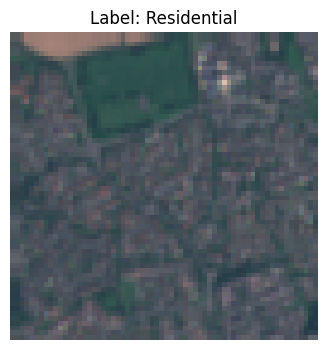

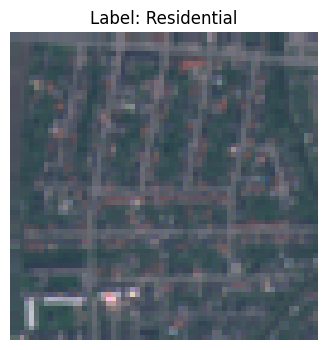

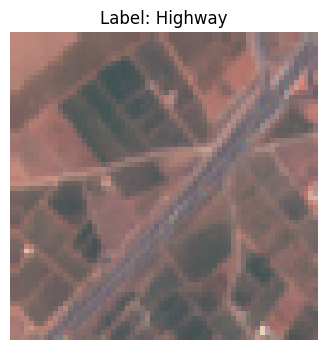

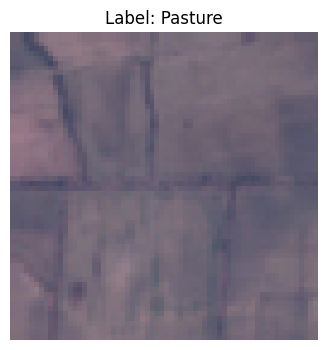

In [65]:
torch.manual_seed(248) # For reproducibility
for i in torch.randint(len(dataset), (4,)): # Pick 4 random samples
  sample = dataset[i]
  dataset.plot(sample) # Plot the images (two residentials, a highway and pasture)

## **Splitting the dataset**

Since we are convinced that we have our dataset, which is input output pair, we can now split it into:
* $train$ - for training the model parameters
* $val$ - for validating the model hyperparameters, and
* $test$ - for testing model performance

Lucky enough, we do not have to worry about the splitting because the data has been split apriori. We only need to indicate the $split$ argument in the `EuroSAT100` function as follows:

In [66]:
train_dataset = EuroSAT100(path, split = 'train')
val_dataset = EuroSAT100(path, split = 'val')
test_dataset = EuroSAT100(path, split = 'test')

## **Data Laoding**
To train our model, validate and test, we need to load data from directory to it. Normally, we work with huge amount of data, not as few as 100 images in this case. Therefore, normally, we cannot load all the data into the RAM of our computer and train the model on it. Accordingly, we need a system which is capable of loading the data in mini-batches so that at every instance, only a few images are present in the RAM for training. To do this, we depend on DataLoaders. The only decision we have to make here is how many images we want to load in the RAM at a time, a value called $batch size$.

In [67]:
batch_size = 10

train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle=False)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)

At this point, it is important to verify that the data loaders are working as expected. That is, they are able to bring data from specified directory and avail them ready for model building. Let us start with train_dataloader.

In [68]:
for batch in train_dataloader:
  print(batch.keys())
  image = batch["image"]
  label = batch["label"]
  print(f"Shape of the image is: {image.shape}")
  print(f"Shape of the label is: {label.shape}")
  break

dict_keys(['image', 'label'])
Shape of the image is: torch.Size([10, 13, 64, 64])
Shape of the label is: torch.Size([10])


We notice that in each batch dictionary, there is image and label keys. Each batch has 10 images, each with 13 channels, and 64 * 64 in height and width dimensions.
On the other hand, each batch as 10 labels corresponding to each of the 10 images. To expound on the 10 labels, they are as follows:
* 0 == Annual crop
* 1 == Forest
* 2 == Herbaceous vegetation
* 3 == Highway
* 4 == Industrial building
* 5 == Pasture
* 6 == Permanent crop
* 7 == Residential building
* 8 == River
* 9 == Sea or Lake

Now we do the same for the val and test sets.

In [69]:
for batch in val_dataloader:
  print(batch.keys())
  image = batch["image"]
  label = batch["label"]
  print(f"Shape of the image is: {image.shape}")
  print(f"Shape of the label is: {label.shape}")
  break

dict_keys(['image', 'label'])
Shape of the image is: torch.Size([10, 13, 64, 64])
Shape of the label is: torch.Size([10])


In [70]:
for batch in test_dataloader:
  print(batch.keys())
  image = batch["image"]
  label = batch["label"]
  print(f"Shape of the image is: {image.shape}")
  print(f"Shape of the label is: {label.shape}")
  break

dict_keys(['image', 'label'])
Shape of the image is: torch.Size([10, 13, 64, 64])
Shape of the label is: torch.Size([10])


## **Transforming datasets**

From the raw data that is loaded in mini-batch by the dataloaders, one may need to do a number of transformations/augmentations. The transformations are nowmally divided into two:
1. Preprocessing - This is meant to make ML-ready data. For example, normalizing the values.
2. Augmentation - Meant to inflate the size of data, for example, rotation and flipping.

These can be implemented as follows:

In [71]:
means = []
stds = []

# Iterate over the DataLoader
for batch in train_dataloader:
    images = batch['image']  # Get images
    means.append(images.mean(dim=(0, 2, 3)))  # Mean across batch, height, and width
    stds.append(images.std(dim=(0, 2, 3)))  # Standard deviation across batch, height, and width

# Convert lists to tensors and compute the overall mean and std
mean_per_band = torch.stack(means).mean(dim=0)
std_per_band = torch.stack(stds).mean(dim=0)

print("Mean per band:", mean_per_band)
print("Standard deviation per band:", std_per_band)

Mean per band: tensor([1335.4720, 1087.1962, 1000.6180,  893.7280, 1159.7341, 2018.0875,
        2399.8557, 2326.0886,  730.7290,   11.8932, 1824.1421, 1112.2601,
        2636.4753])
Standard deviation per band: tensor([ 207.9270,  298.7845,  348.1283,  522.0065,  473.8945,  747.6469,
         947.1871,  986.6773,  375.3021,    3.5969,  852.6541,  684.7718,
        1063.6451])


In [72]:
preprocess = K.Normalize(mean = [1335.4720, 1087.1960, 1000.6181,  893.7280, 1159.7341, 2018.0876,
        2399.8557, 2326.0886,  730.7291,   11.8932, 1824.1420, 1112.2600,
        2636.4753],
                         std = [221.3967,  313.6509,  361.3128,  529.4099,  497.7751,  846.1222,
        1068.4669, 1098.9768,  411.7481,    3.9491,  935.4077,  716.1664,
        1206.4883])

On the other hand, for augmentation, we can have one or more in a sequence as follows:

In [73]:
augment = K.ImageSequential(K.RandomHorizontalFlip(),
                            K.RandomVerticalFlip())

## **Model Building**

Once we have appropriate data loaders bringing in data and the transformations acting on the loaded datasets, it is time to build the model. There exists a lot of pretrained models which we can work with. In this case, we will use `restnet18` and its associated weights relevant for sentinel2 dataset we are working with.

In [74]:
model = resnet18(ResNet18_Weights.SENTINEL2_ALL_MOCO)

### **Calculating loss function**

In deep learning, the dataset is normally exposed to the model several times. Each time a model sees all data is called $epoch$. After the model has learnt through the data, we can determine how far away from actual labels, $y$, the predictions $\hat{y}$ are. This is normally achieved through a $loss$ $function$. The purpose of loss function is to aim at reducing the difference between actual labels and predicted labels after every training run, $epoch$.

In [75]:
loss_fn = nn.CrossEntropyLoss()

## **Optimizers**

After calculating the loss, difference between observed and predicted output, minimizing the loss involves taking a small step, $learning$ $rate$, in the direction of negative gradient ($backpropagation$). This is done one image or mini-batch at a time; stochastic gradient descent (SGD) as follows.

In [76]:
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

## **Moving data and model to device**

Normally, the linear algebraic calculations involved in deep learning are better handled on the GPU. So, both data and model need to be transferred from CPU to GPU to enable efficient training. This can be achieved by:

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

We can check what our device is here:

In [78]:
device # Returns 'cpu' because we did not yet set it to GPU in the runtime.

'cpu'

## **Training the model**

This involves setting the model to train mode then iterating over the mini-batches in the dataset. During the forward pass, we ask the model to predict y given x. During backward pass, we do backpropagation in which we update model weights. This can be achieved as follows:

In [79]:
def train(dataloader):
  model.train()
  total_loss = 0
  for batch in dataloader:
    x = batch['image'].to(device)
    y = batch['label'].to(device)

    # Forward pass
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    total_loss += loss.item()

    # Backward pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  print(f"Loss: {total_loss:.2%}")

## **Evaluating the model**

After training a model, we should evaluate it on unseen data to see how it performs. This involves setting the model to evaluation mode then iterating through the minibatches. We do not engage backpropagation here but compute the number of correctly classified images.

In [104]:
def evaluate(dataloader):
  model.eval()
  correct = 0.0
  with torch.no_grad():
    for batch in dataloader:
      x = batch['image'].to(device)
      y = batch['label'].to(device)

      # Forward pass
      y_hat = model(x)
      correct += (y_hat.argmax(1) == y).float().sum().item()

  correct /= len(dataloader.dataset)
  print(f"Accuracy: {correct:.0%}")

## **Running for x epochs**

Now we need to run this several times so that our model can learn and improve over time. Say, we want to run it 20 times. This means we set epochs to 20 as follows:

In [94]:
epochs = 20

Normally, we would set such number of epochs that ensures that we see reduction in loss and increase in accuracy. Better still, we want to train the model until the validation accuracy starts to plateau or even decrease. At that point the model shall have sufficiently learnt.

In [105]:
for epoch in range(epochs):
  print(f"Epoch: {epoch}")
  train(train_dataloader)
  evaluate(val_dataloader)

Epoch: 0
Loss: 3307.50%
Accuracy: 55%
Epoch: 1
Loss: 3307.92%
Accuracy: 60%
Epoch: 2
Loss: 3148.82%
Accuracy: 55%
Epoch: 3
Loss: 3059.73%
Accuracy: 55%
Epoch: 4
Loss: 2998.87%
Accuracy: 60%
Epoch: 5
Loss: 3006.87%
Accuracy: 55%
Epoch: 6
Loss: 2863.48%
Accuracy: 50%
Epoch: 7
Loss: 2819.90%
Accuracy: 55%
Epoch: 8
Loss: 2723.50%
Accuracy: 60%
Epoch: 9
Loss: 2668.55%
Accuracy: 60%
Epoch: 10
Loss: 2612.05%
Accuracy: 55%
Epoch: 11
Loss: 2381.96%
Accuracy: 60%
Epoch: 12
Loss: 2425.18%
Accuracy: 60%
Epoch: 13
Loss: 2281.63%
Accuracy: 55%
Epoch: 14
Loss: 2300.83%
Accuracy: 55%
Epoch: 15
Loss: 2261.37%
Accuracy: 55%
Epoch: 16
Loss: 2304.64%
Accuracy: 60%
Epoch: 17
Loss: 2088.33%
Accuracy: 60%
Epoch: 18
Loss: 1985.18%
Accuracy: 60%
Epoch: 19
Loss: 2009.19%
Accuracy: 60%


These are of course horrible performance, however, suited for this simple introductory workflow.

In [111]:
evaluate(test_dataloader)

Accuracy: 80%


## **References**
[PyTorch: Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)

[Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

[Transfer learning for Computer Vision](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)